In [1]:
import sys
sys.path.append('../')
from src import mlp_quantile
from src import metrics as _metrics
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 
import seaborn as sns

sns.set(rc={'figure.figsize':(20,8)})
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
pd.set_option('display.max_rows', 120)

* https://towardsdatascience.com/quantile-regression-from-linear-models-to-trees-to-deep-learning-af3738b527c3
* https://towardsdatascience.com/lightgbm-for-quantile-regression-4288d0bb23fd
* https://towardsdatascience.com/deep-quantile-regression-in-tensorflow-1dbc792fe597
* https://github.com/sachinruk/KerasQuantileModel/blob/master/Keras%20Quantile%20Model.ipynb

## Reading / Displaying the Data 

In [2]:
df_dataset_v2 = pd.read_csv('../data/forecast_dataset_exp1.csv')

In [3]:
df_dataset_v2.describe()

,month,unit_markup,Y,hc_cluster_1,hc_cluster_2,hc_cluster_3,hc_cluster_4,hc_cluster_5,hc_cluster_6,hc_cluster_7,...,cat_code_1,cat_code_2,cat_code_3,cat_code_4,cat_code_5,cat_code_6,cat_code_7,cat_code_8,cat_code_9,cat_code_10
count,11190.000000,11190.000000,11190.000000,11190.000000,11190.000000,11190.000000,11190.000000,11190.00000,11190.000000,11190.000000,...,11190.000000,11190.000000,11190.000000,11190.000000,11190.000000,11190.000000,11190.000000,11190.000000,11190.000000,11190.000000
mean,6.231993,1.696202,13.589097,0.351921,0.533691,0.004558,0.020554,0.01412,0.009562,0.001519,...,0.002860,0.001787,0.003664,0.055764,0.009562,0.020554,0.001519,0.003307,0.010813,0.004558
std,3.594115,0.414477,34.622201,0.477591,0.498886,0.067359,0.141892,0.11799,0.097322,0.038949,...,0.053402,0.042241,0.060423,0.229476,0.097322,0.141892,0.038949,0.057410,0.103428,0.067359
min,1.000000,0.500000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,1.400000,2.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,1.700000,4.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,10.000000,2.000000,11.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,12.000000,4.800000,643.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
df_dataset_v2.head()

,code,year_month,month,unit_markup,Y,hc_cluster_1,hc_cluster_2,hc_cluster_3,hc_cluster_4,hc_cluster_5,...,cat_code_1,cat_code_2,cat_code_3,cat_code_4,cat_code_5,cat_code_6,cat_code_7,cat_code_8,cat_code_9,cat_code_10
0,0671c2b9132a3f5215a4212ce0691694,2016-11,11,1.1,53,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0671c2b9132a3f5215a4212ce0691694,2016-11,11,1.2,92,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0671c2b9132a3f5215a4212ce0691694,2016-11,11,1.3,28,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0671c2b9132a3f5215a4212ce0691694,2016-11,11,1.4,61,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0671c2b9132a3f5215a4212ce0691694,2016-11,11,1.5,21,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
X_cols = [c for c in df_dataset_v2.columns if c not in ['year_month', 'Y'] and 'hc_cluster' not in c]

In [6]:
df_dataset_v2['code'] = df_dataset_v2['code'].astype('category').cat.codes

In [7]:
df_dataset_v2[X_cols].head()

,code,month,unit_markup,kmeans_cluster_0,kmeans_cluster_1,kmeans_cluster_2,kmeans_cluster_3,kmeans_cluster_4,kmeans_cluster_5,kmeans_cluster_6,...,cat_code_1,cat_code_2,cat_code_3,cat_code_4,cat_code_5,cat_code_6,cat_code_7,cat_code_8,cat_code_9,cat_code_10
0,0,11,1.1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,11,1.2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,11,1.3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,11,1.4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,11,1.5,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Splitting the Sets
* We will use the temporal series cross validation
* 3 months minimum intervals
* 3 training, 6 validation, 3 test
* 4 training, 5 validation, 3 test
* 5 training, 4 validation, 3 test
* 6 training, 3 validation, 3 test

In [8]:
df_train_val_test = pd.read_csv('../data/train_val_test.csv')

In [9]:
df_train_val_test

,set,train,val,reserved
0,0,"['2016-06', '2016-07', '2016-08']","['2016-09', '2016-10', '2016-11', '2016-12', '...",False
1,1,"['2016-06', '2016-07', '2016-08', '2016-09']","['2016-10', '2016-11', '2016-12', '2017-01', '...",False
2,2,"['2016-06', '2016-07', '2016-08', '2016-09', '...","['2016-11', '2016-12', '2017-01', '2017-02']",False
3,3,"['2016-06', '2016-07', '2016-08', '2016-09', '...","['2016-12', '2017-01', '2017-02']",False
4,4,"['2016-06', '2016-07', '2016-08', '2016-09', '...","['2017-01', '2017-02']",False
5,5,"['2016-06', '2016-07', '2016-08', '2016-09', '...",['2017-02'],False
6,6,"['2016-06', '2016-07', '2016-08', '2016-09', '...","['2017-03', '2017-04', '2017-05']",True


## Regressors Init

In [10]:
regressors = {}
RANDOM_STATE = 42
q =0.5

In [11]:
import lightgbm as lgb
gbm = lgb.LGBMRegressor(random_state=RANDOM_STATE)
regressors['gbm'] = gbm

In [12]:
import lightgbm as lgb
gbm_q = lgb.LGBMRegressor(alpha=q, objective = 'quantile',
    metric = 'quantile',random_state=RANDOM_STATE)
regressors['gbm_q'] = gbm_q

In [13]:
from sklearn.ensemble import GradientBoostingRegressor
gb_q = GradientBoostingRegressor(loss='quantile', alpha=q)
regressors['gb_q'] = gb_q

In [14]:

mlp_q = mlp_quantile.QuantileModel(input_dims=len(X_cols), q=q)
regressors['mlp_q'] = mlp_q

In [15]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## Train Eval



In [16]:
def parse_str_list(str_list):
    result = str_list.replace("'","").replace('[','').replace(']','').replace(' ', '').split(',')
    return result

In [17]:
sets = list(df_train_val_test[~df_train_val_test.reserved].set.values)
sets

[0, 1, 2, 3, 4, 5]

In [18]:
results = []
for r_name, r in regressors.items():
    for s in sets:
        df_set = df_train_val_test[~df_train_val_test.reserved & (df_train_val_test.set == s)]

        x_scaler = MinMaxScaler()
        
        train_years = parse_str_list(df_set.train.values[0])
        val_years = parse_str_list(df_set.val.values[0])
        print(f'Training {r_name} on set {s}')
        

        df_train = df_dataset_v2[df_dataset_v2.year_month.isin(train_years)]
        df_val = df_dataset_v2[df_dataset_v2.year_month.isin(val_years)]
    
        y_train = df_train['Y'].values    
        y_val = df_val['Y'].values
        
        if 'mlp' in r_name:
            r_inst = r.fit(X=x_scaler.fit_transform(df_train[X_cols]), y=y_train, 
                       X_val = x_scaler.transform(df_val[X_cols]), y_val = y_val)
        else: 
            r_inst = r.fit(X=x_scaler.fit_transform(df_train[X_cols]), y=y_train)
        
        print(f'Validating {r_name}  on set {s}')
        
        y_pred_val = r_inst.predict(x_scaler.transform(df_val[X_cols]))
        
        y_pred_val = y_pred_val
        m = _metrics.applyRegressionMetrics(y=y_val, y_pred=y_pred_val)
        m['reg_inst'] = r_inst
        m['r_name'] = r_name
        m['set'] = s
        results.append(m)

    print()
df_results = pd.DataFrame(results)    

Training gbm on set 0
Validating gbm  on set 0
Training gbm on set 1
Validating gbm  on set 1
Training gbm on set 2
Validating gbm  on set 2
Training gbm on set 3
Validating gbm  on set 3
Training gbm on set 4
Validating gbm  on set 4
Training gbm on set 5
Validating gbm  on set 5

Training gbm_q on set 0
Validating gbm_q  on set 0
Training gbm_q on set 1
Validating gbm_q  on set 1
Training gbm_q on set 2
Validating gbm_q  on set 2
Training gbm_q on set 3
Validating gbm_q  on set 3
Training gbm_q on set 4
Validating gbm_q  on set 4
Training gbm_q on set 5
Validating gbm_q  on set 5

Training gb_q on set 0
Validating gb_q  on set 0
Training gb_q on set 1
Validating gb_q  on set 1
Training gb_q on set 2
Validating gb_q  on set 2
Training gb_q on set 3
Validating gb_q  on set 3
Training gb_q on set 4
Validating gb_q  on set 4
Training gb_q on set 5
Validating gb_q  on set 5

Training mlp_q on set 0
Validating mlp_q  on set 0
Training mlp_q on set 1
Validating mlp_q  on set 1
Training mlp_

In [19]:
metric_list = []

In [20]:
df_results.groupby('r_name').agg({'RMSE':[pd.Series.mean, pd.Series.std],
                                  'MDAPE':[pd.Series.mean, pd.Series.std],'MAPE':[pd.Series.mean, pd.Series.std],
                                  'MSE':[pd.Series.mean, pd.Series.std],
                                  'MAE':[pd.Series.mean, pd.Series.std],'R2':[pd.Series.mean, pd.Series.std],})

RMSE               MDAPE                MAPE            \
             mean       std      mean       std      mean       std   
r_name                                                                
gb_q    32.230122  3.787281  0.705020  0.011461  1.121858  0.142459   
gbm     24.438277  4.359426  0.825441  0.063726  2.233189  0.218267   
gbm_q   28.146835  4.008227  0.694146  0.023585  1.262537  0.094612   
mlp_q   34.345282  4.635864  1.079182  0.262255  2.698596  0.965694   

                MSE                    MAE                  R2            
               mean         std       mean       std      mean       std  
r_name                                                                    
gb_q    1050.733666  222.631598  10.592675  1.472081  0.053415  0.051321  
gbm      613.066519  188.772662  10.713942  1.592821  0.457694  0.099835  
gbm_q    805.632541  201.357810  10.102235  1.500612  0.279894  0.078652  
mlp_q   1197.507776  297.050703  13.882744  3.560008 -0.075084  0.123595

Training gbm on set 6
Validating gbm on set 6 and 2017-03
7626 1073
RMSE : 23.0647
MAPE': 1.7773
MDAPE': 0.6765
MSE: 531.9823
MAE: 9.3504
R2: 0.5439


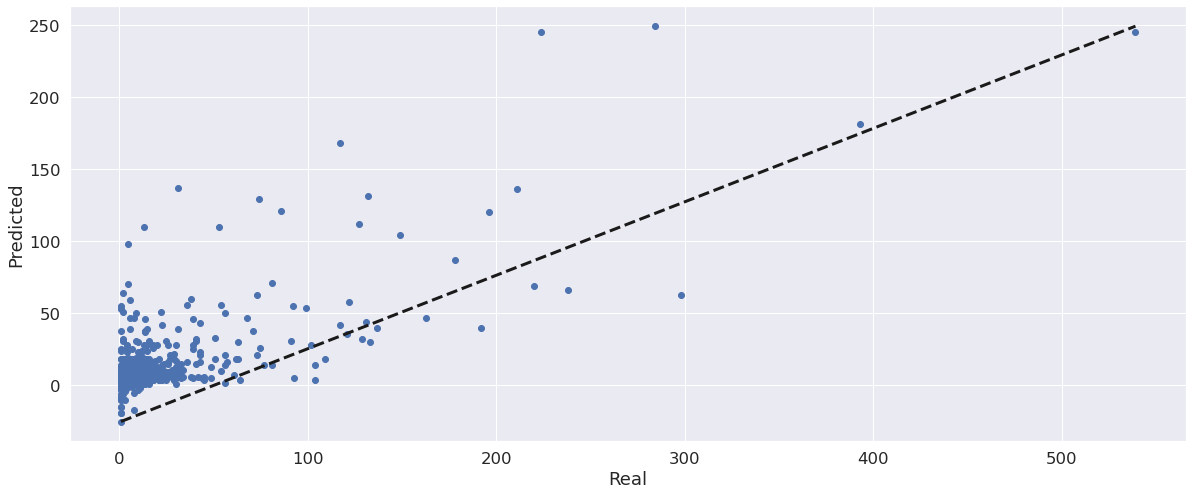

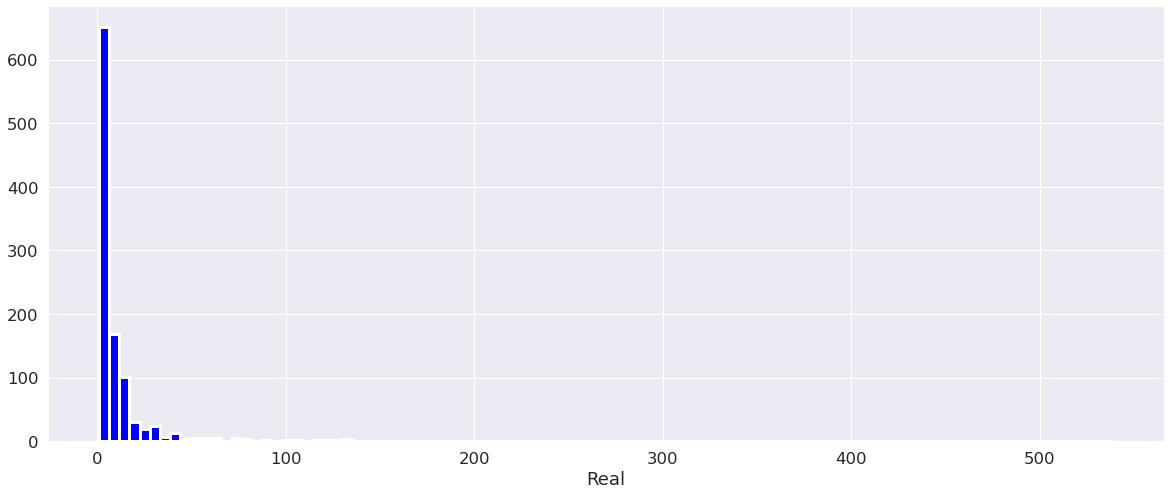

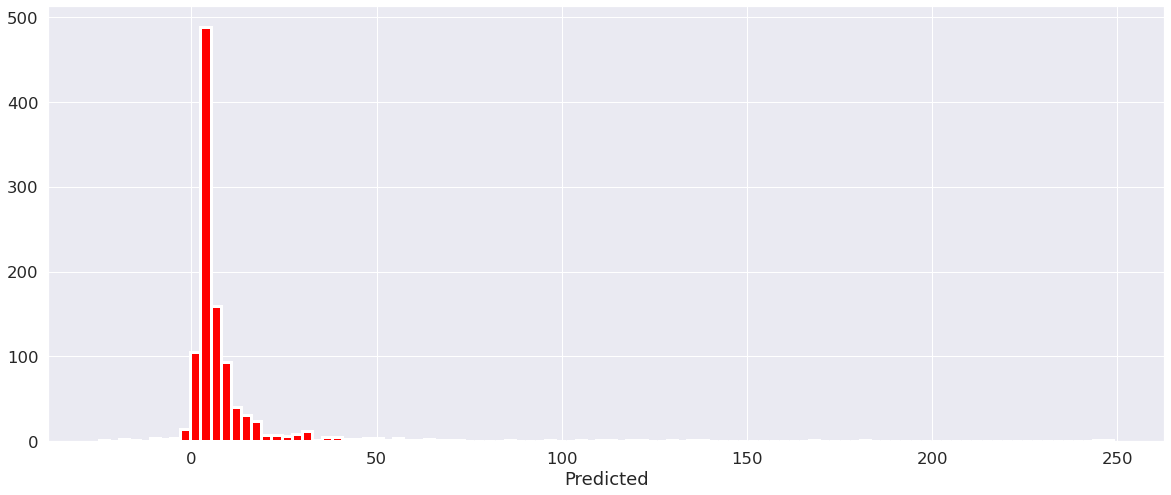


Validating gbm on set 6 and 2017-04
7626 1068
RMSE : 23.6589
MAPE': 1.9835
MDAPE': 0.6667
MSE: 559.7416
MAE: 9.2397
R2: 0.4146


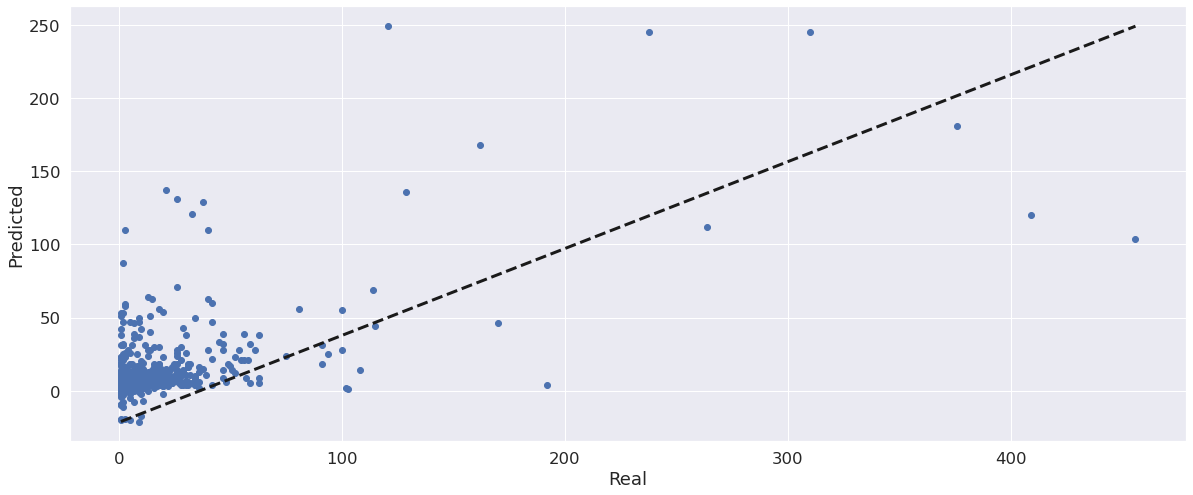

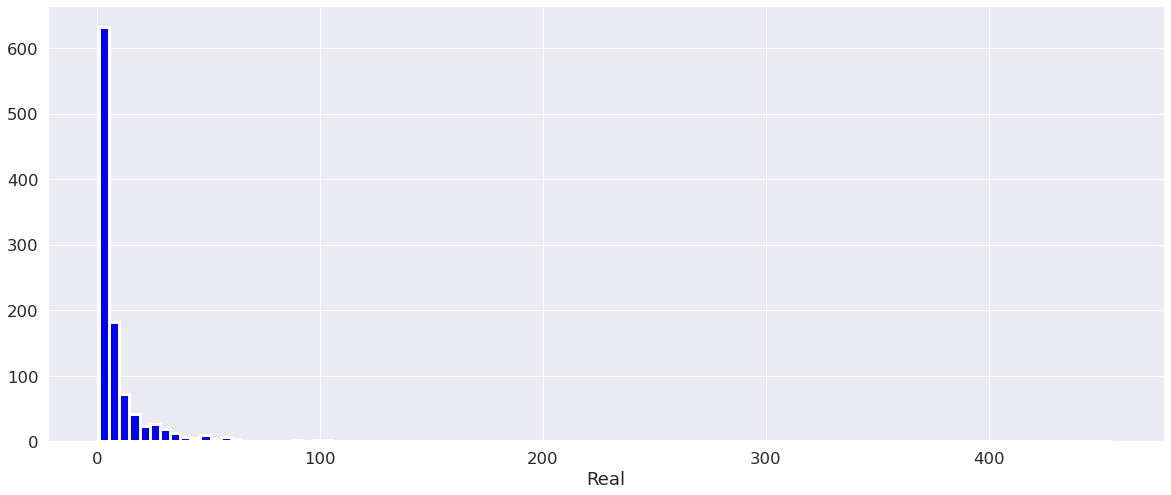

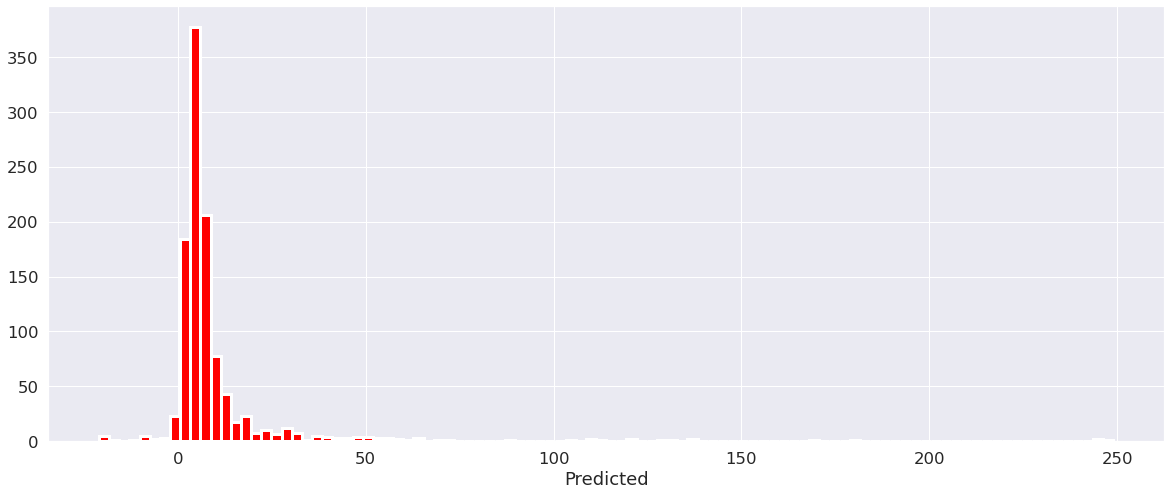


Validating gbm on set 6 and 2017-05
7626 1171
RMSE : 32.7422
MAPE': 1.7253
MDAPE': 0.6667
MSE: 1072.0521
MAE: 11.2101
R2: 0.3470


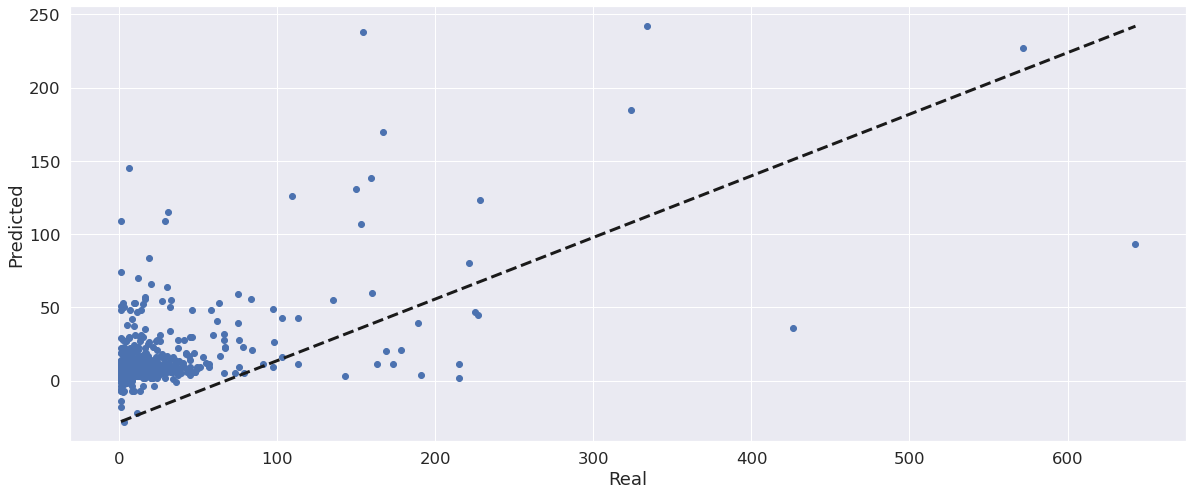

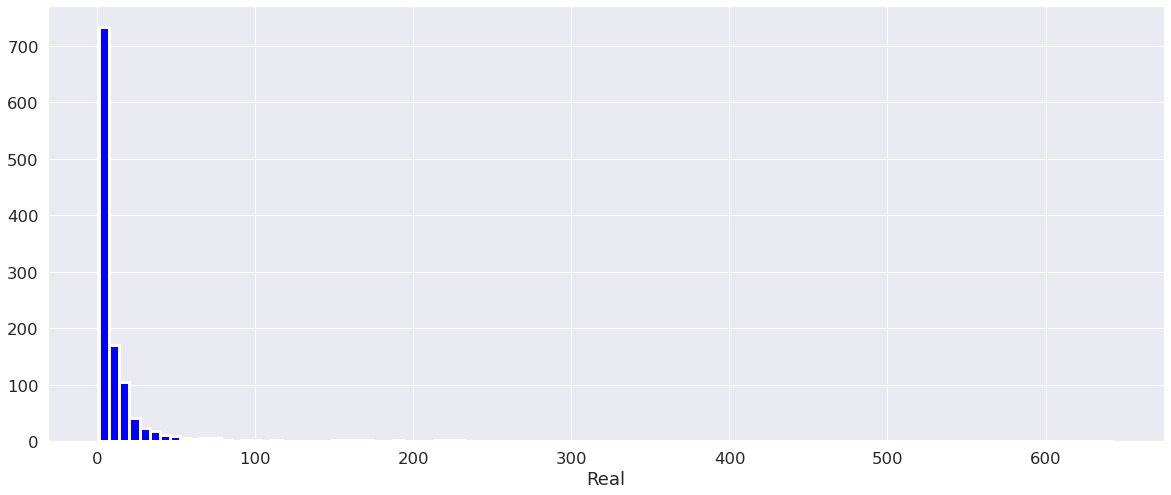

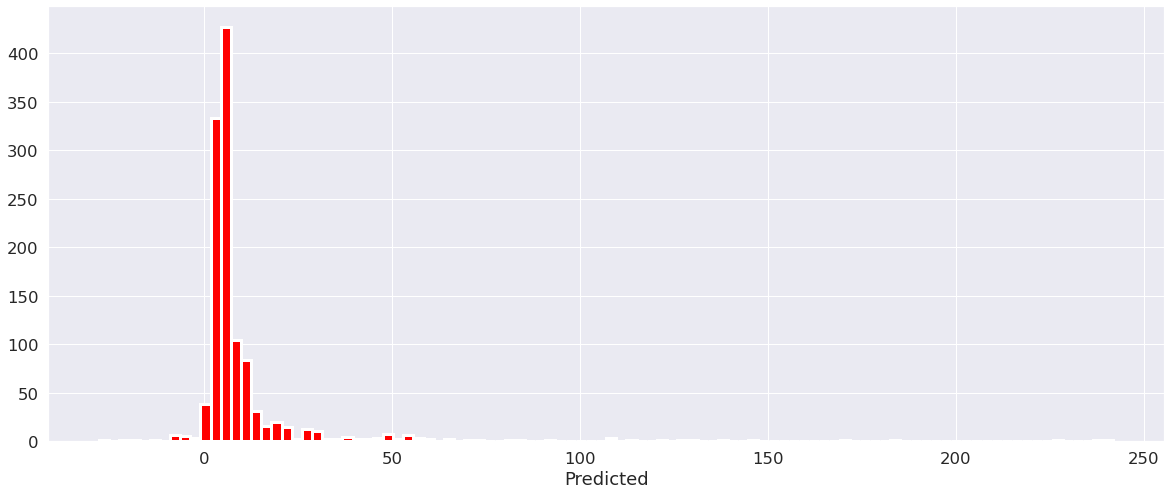


Training gbm_q on set 6
Validating gbm_q on set 6 and 2017-03
7626 1073
RMSE : 27.8022
MAPE': 1.1299
MDAPE': 0.6000
MSE: 772.9637
MAE: 9.5042
R2: 0.3373


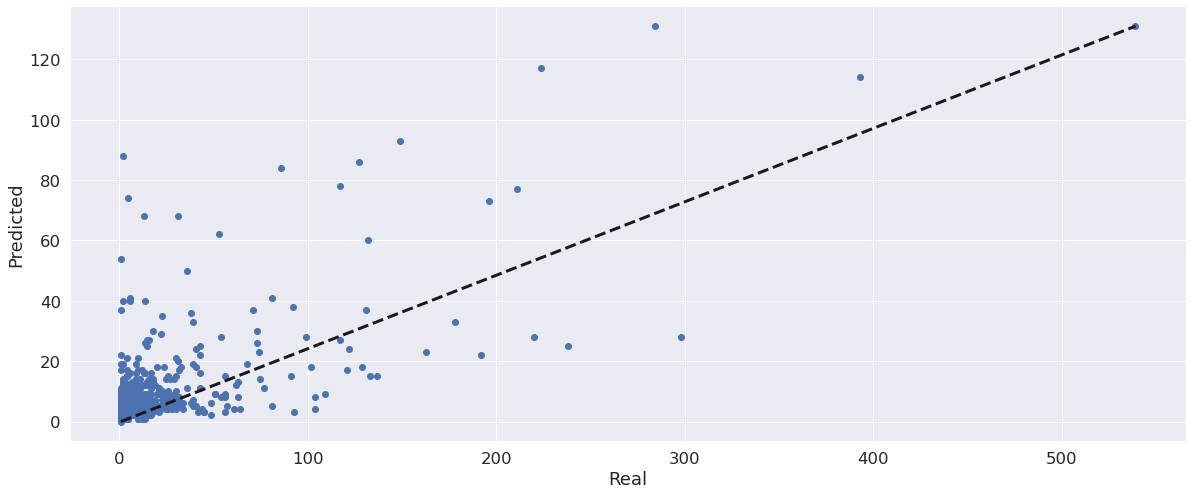

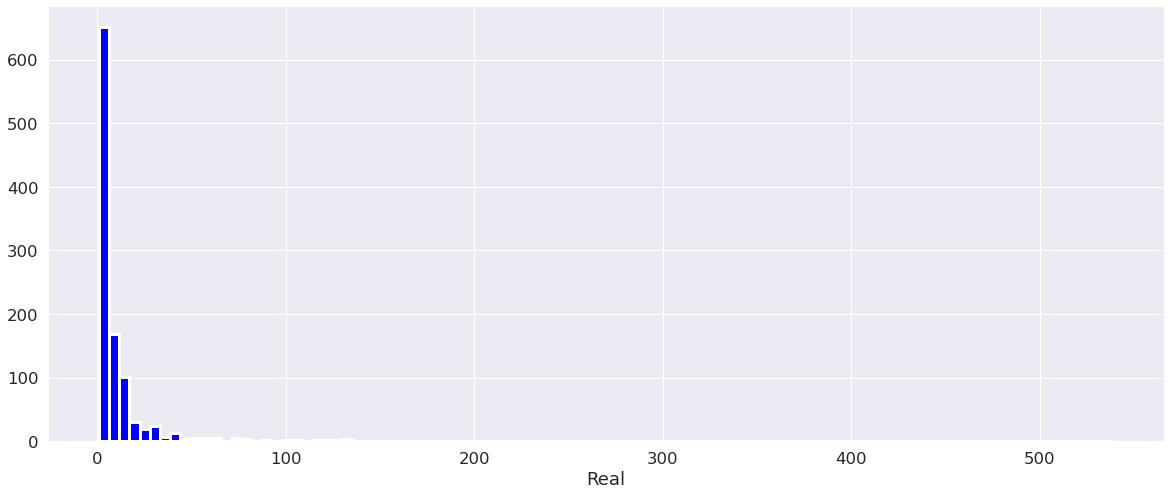

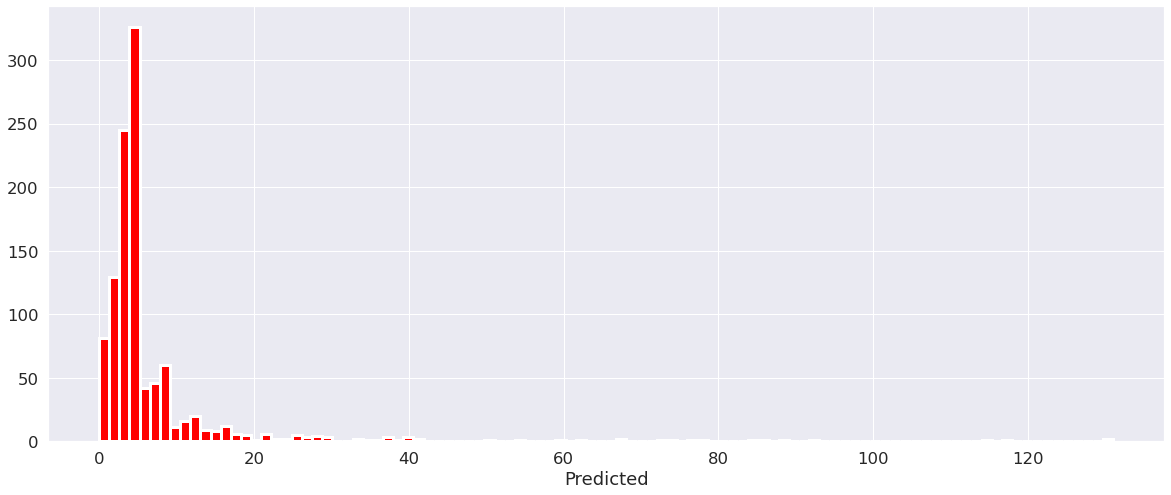


Validating gbm_q on set 6 and 2017-04
7626 1068
RMSE : 24.9513
MAPE': 1.3114
MDAPE': 0.6250
MSE: 622.5665
MAE: 8.5946
R2: 0.3488


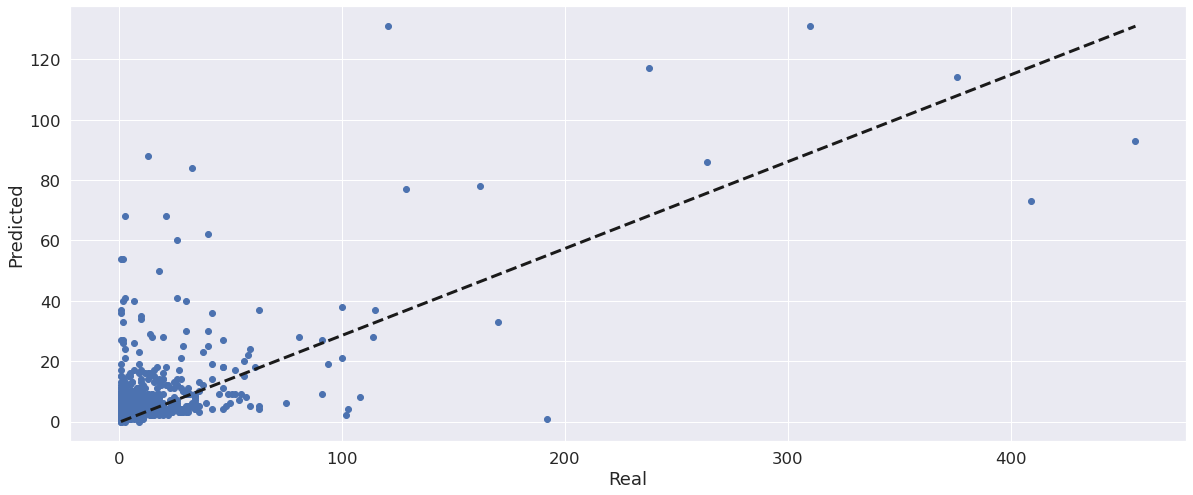

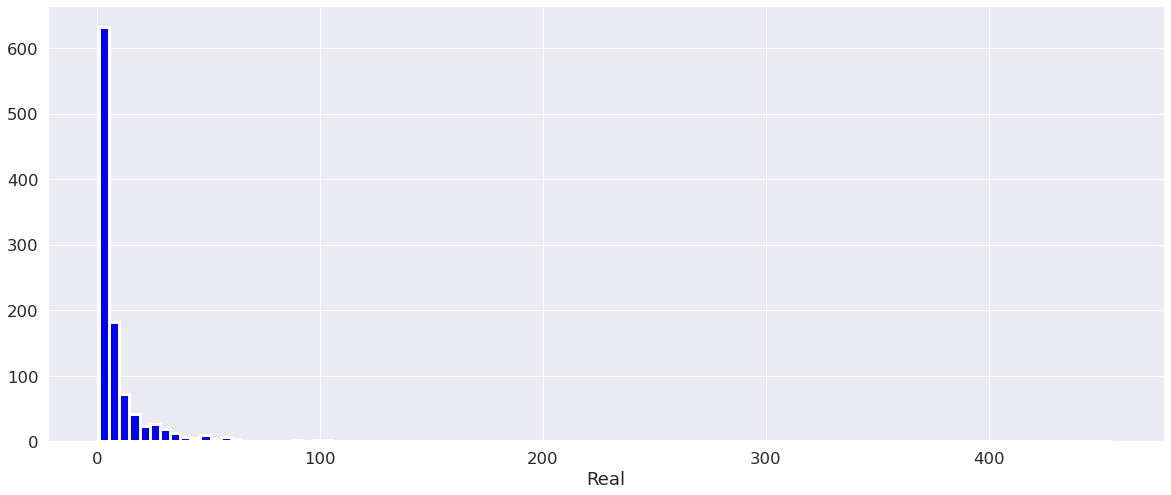

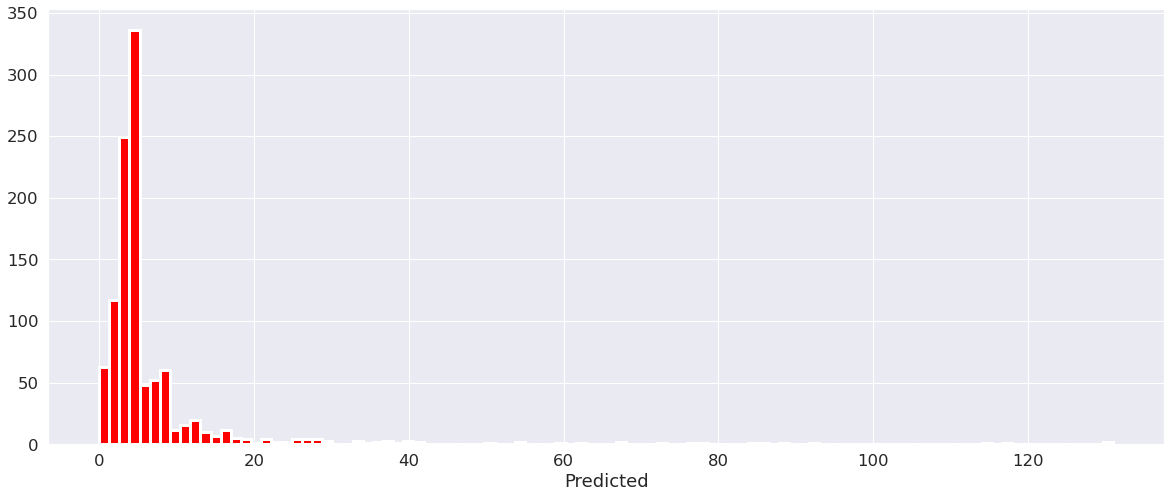


Validating gbm_q on set 6 and 2017-05
7626 1171
RMSE : 35.2473
MAPE': 1.0453
MDAPE': 0.6429
MSE: 1242.3749
MAE: 11.3416
R2: 0.2433


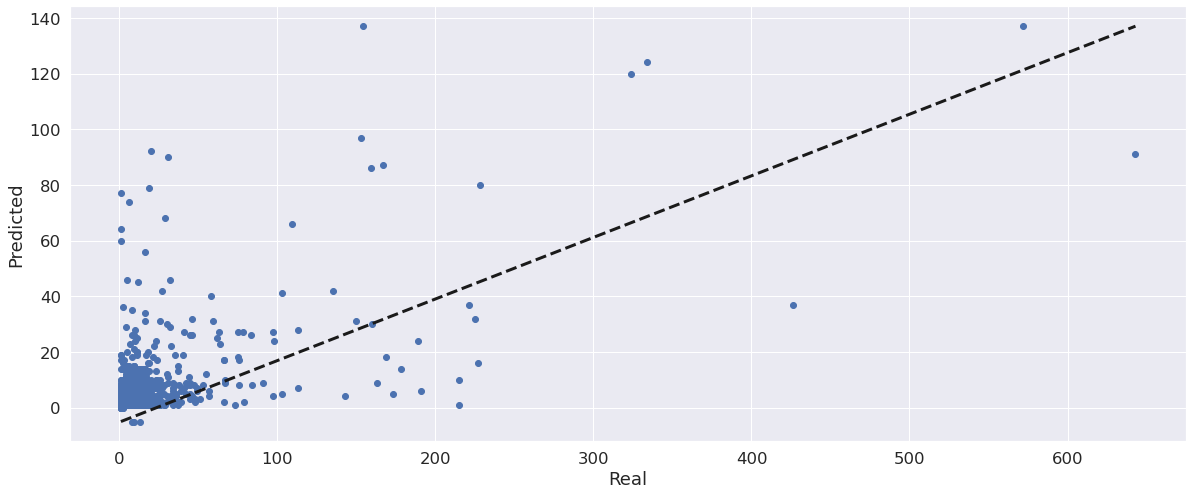

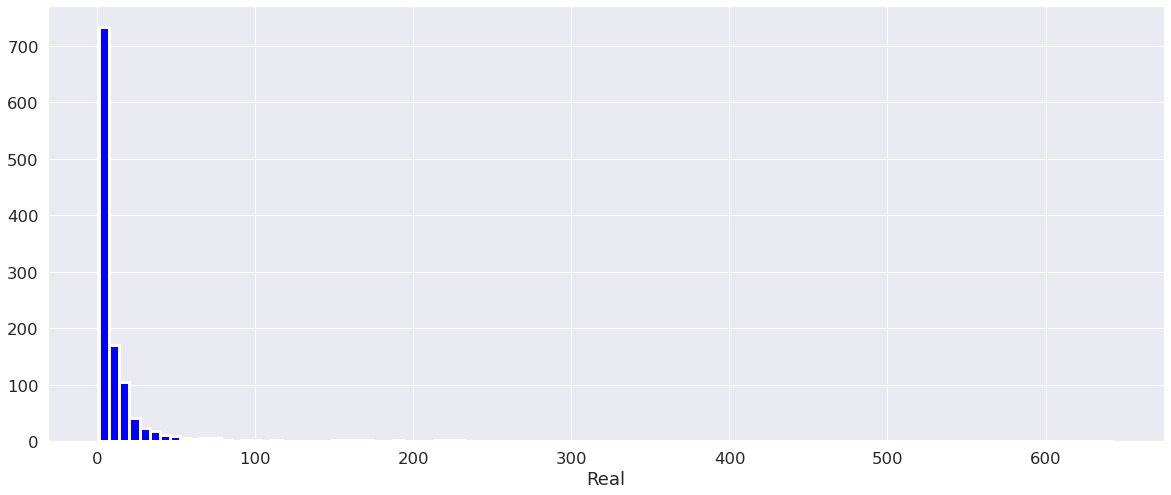

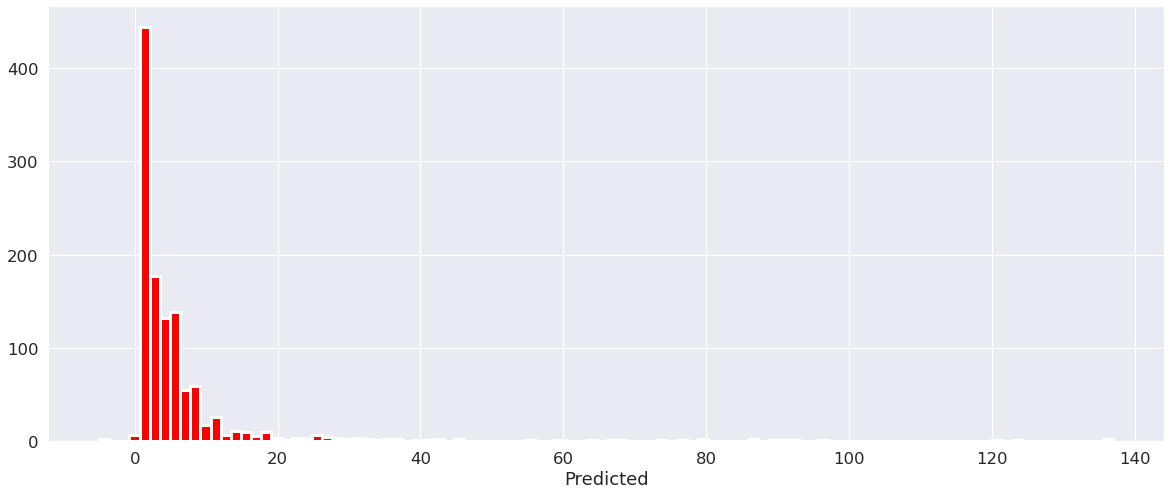


Training gb_q on set 6
Validating gb_q on set 6 and 2017-03
7626 1073
RMSE : 32.5620
MAPE': 1.1431
MDAPE': 0.6667
MSE: 1060.2842
MAE: 10.4856
R2: 0.0910


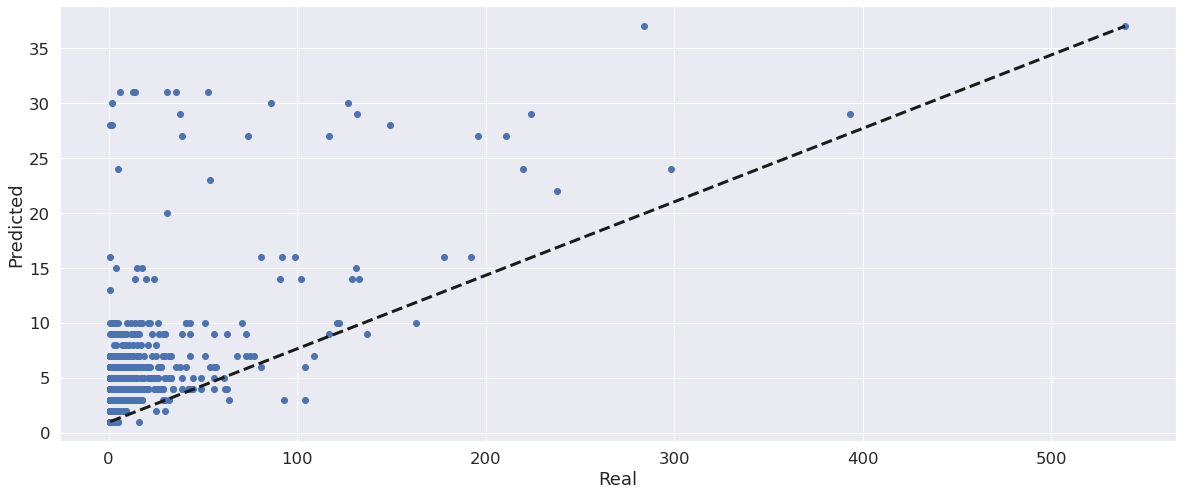

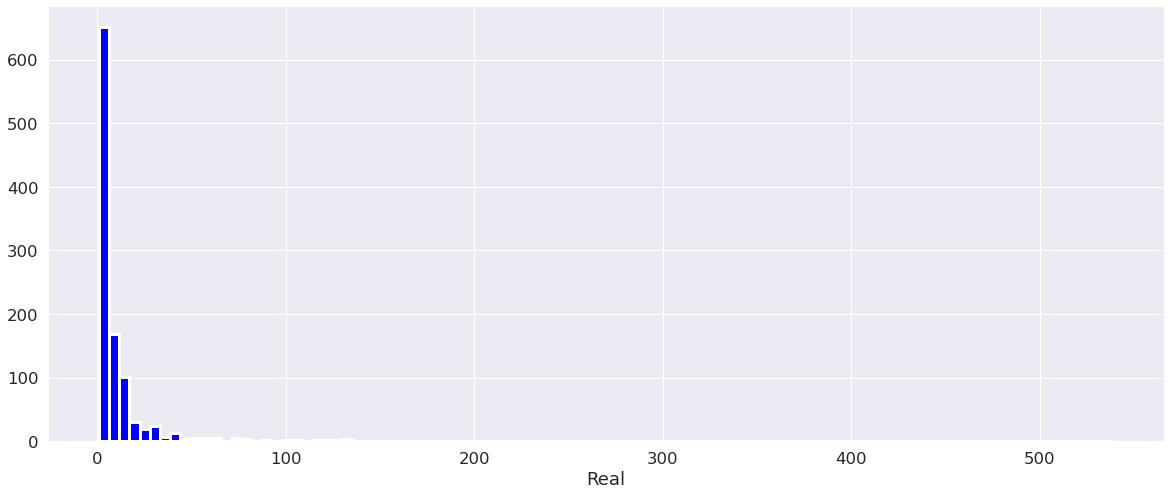

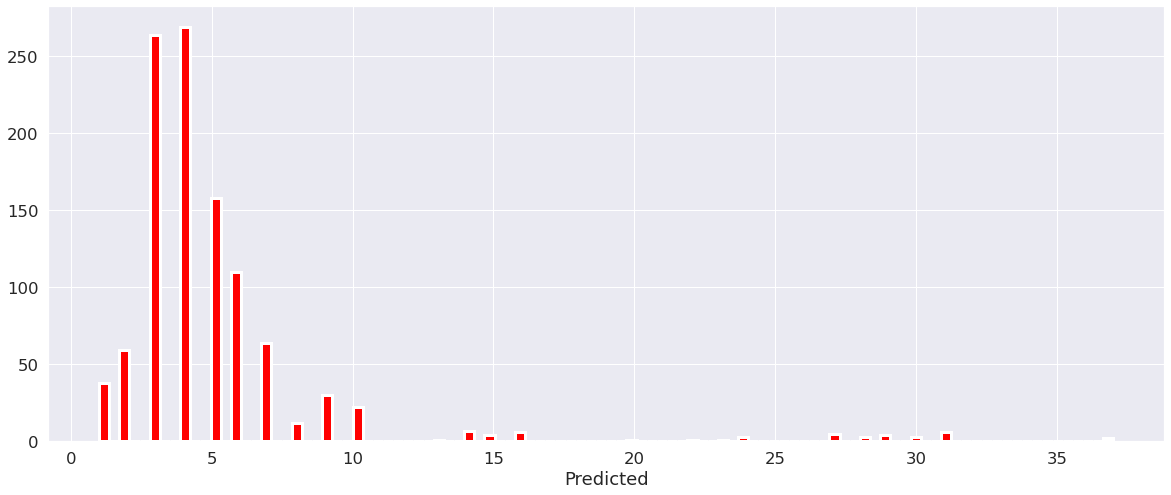


Validating gb_q on set 6 and 2017-04
7626 1068
RMSE : 29.4183
MAPE': 1.1716
MDAPE': 0.6667
MSE: 865.4354
MAE: 9.0590
R2: 0.0948


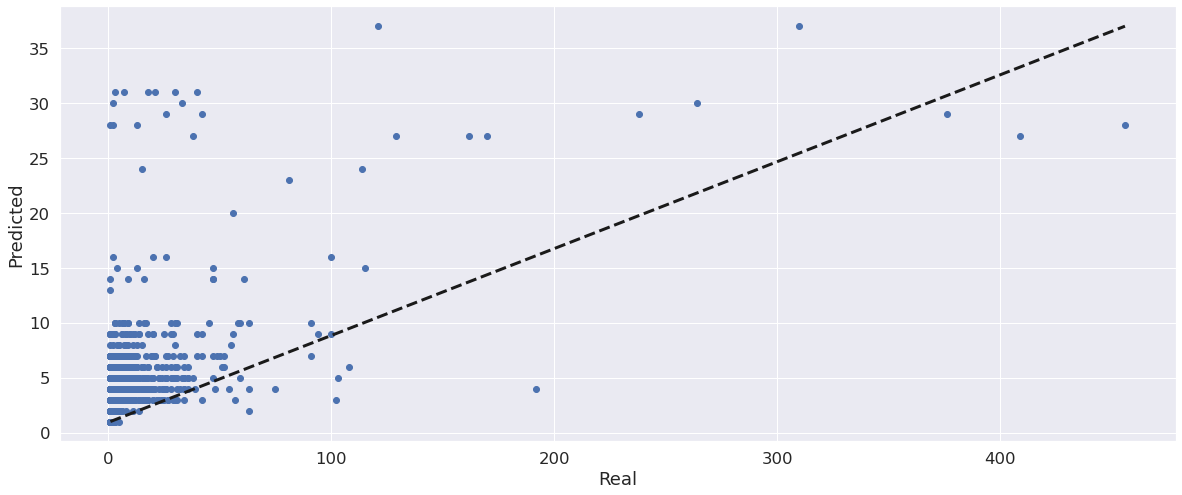

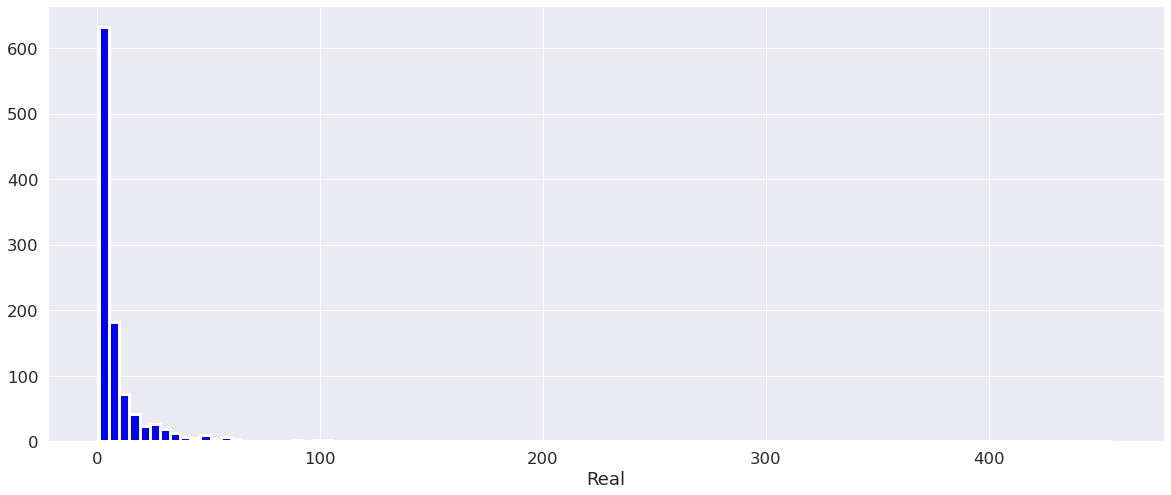

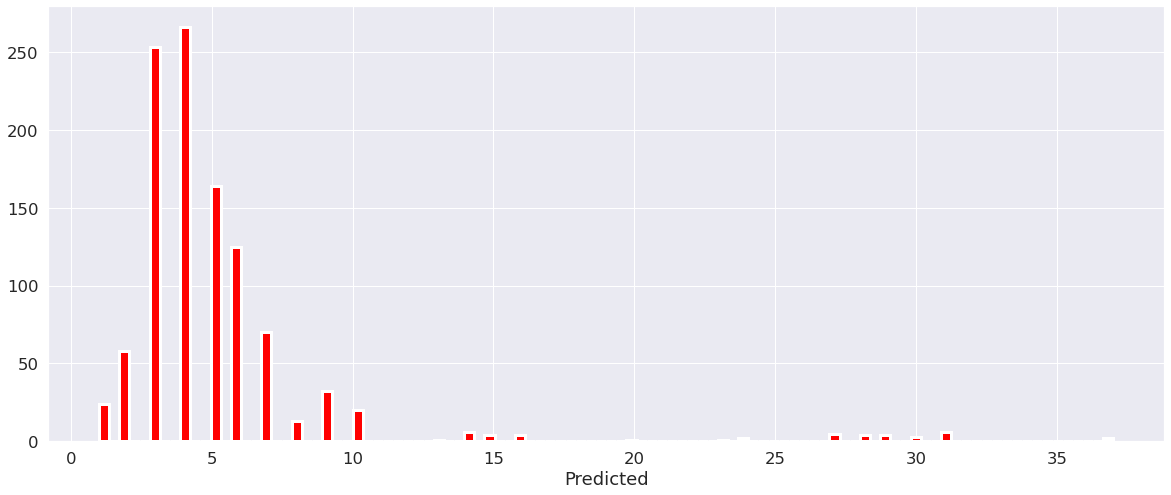


Validating gb_q on set 6 and 2017-05
7626 1171
RMSE : 39.7126
MAPE': 0.9404
MDAPE': 0.6429
MSE: 1577.0905
MAE: 11.8591
R2: 0.0394


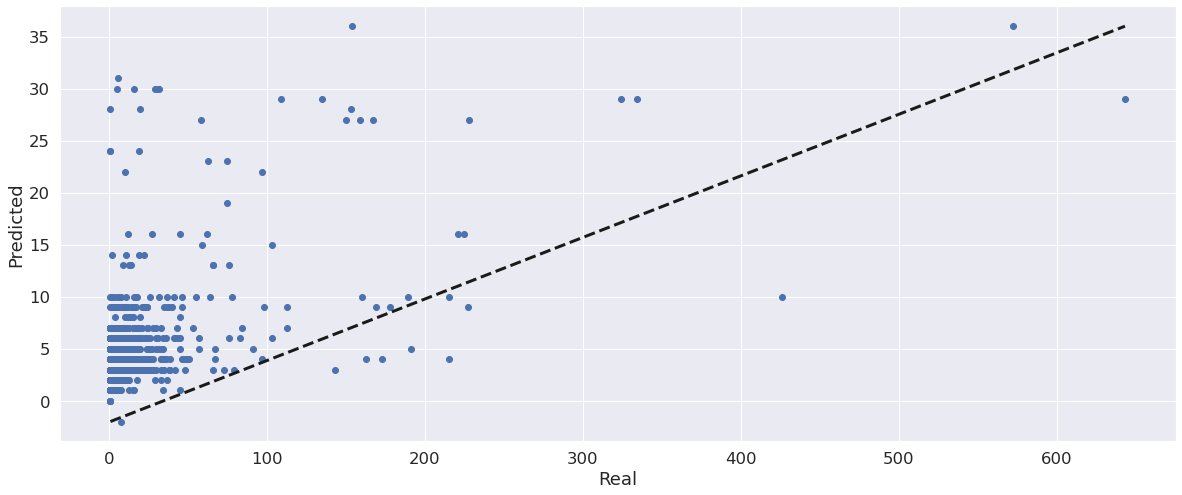

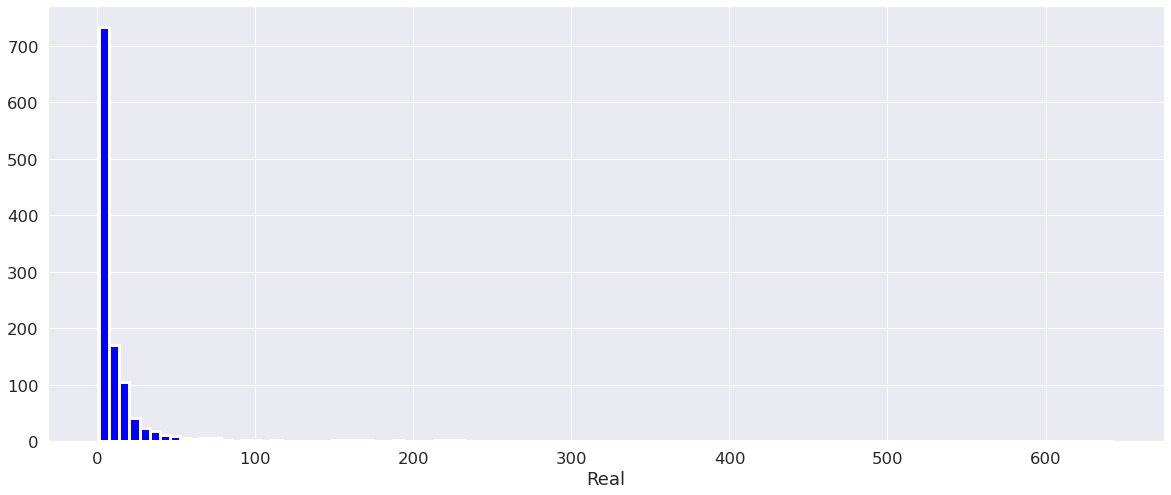

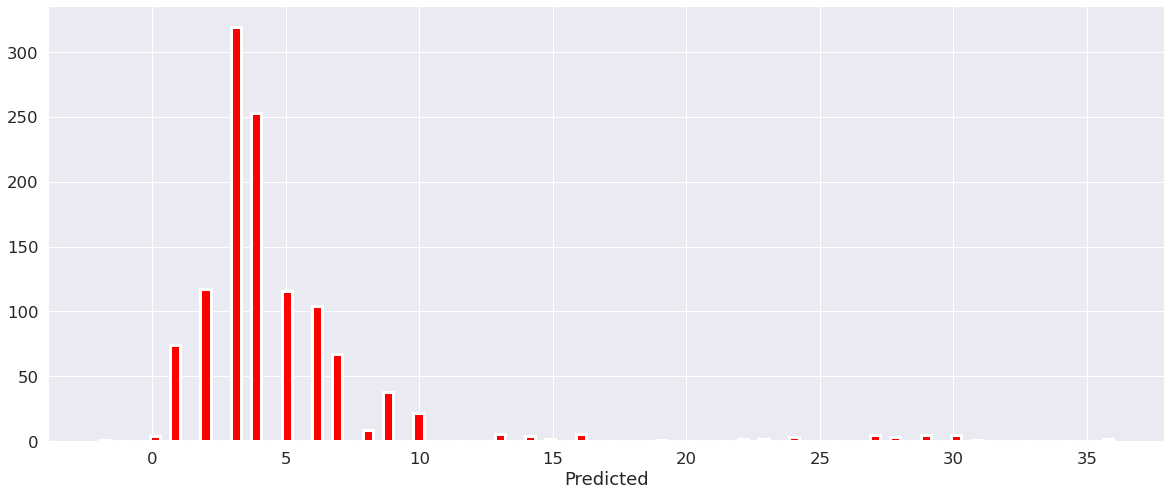


Training mlp_q on set 6
Validating mlp_q on set 6 and 2017-03
7626 1073
RMSE : 34.1406
MAPE': 1.4492
MDAPE': 0.7619
MSE: 1165.5806
MAE: 11.1836
R2: 0.0007


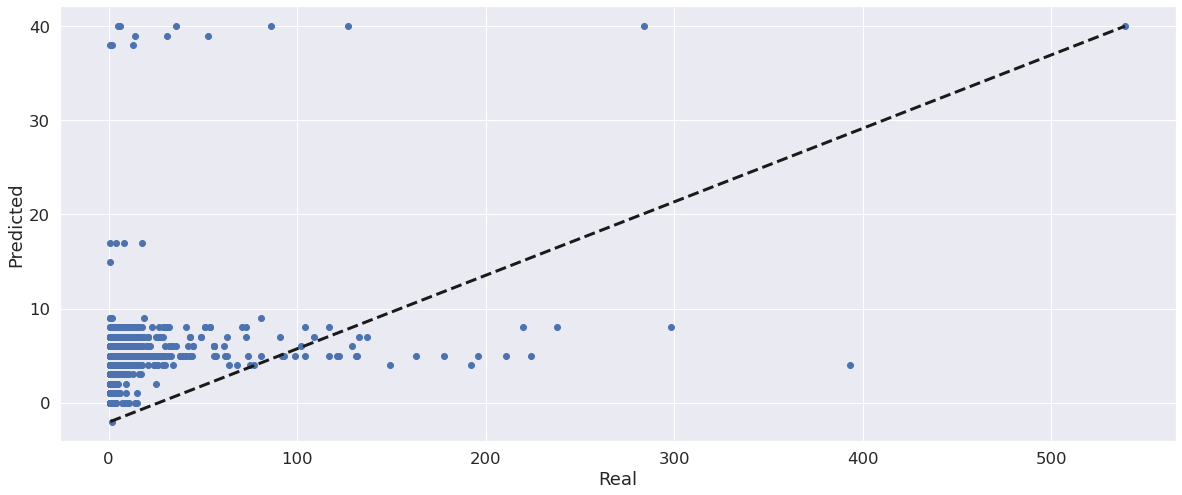

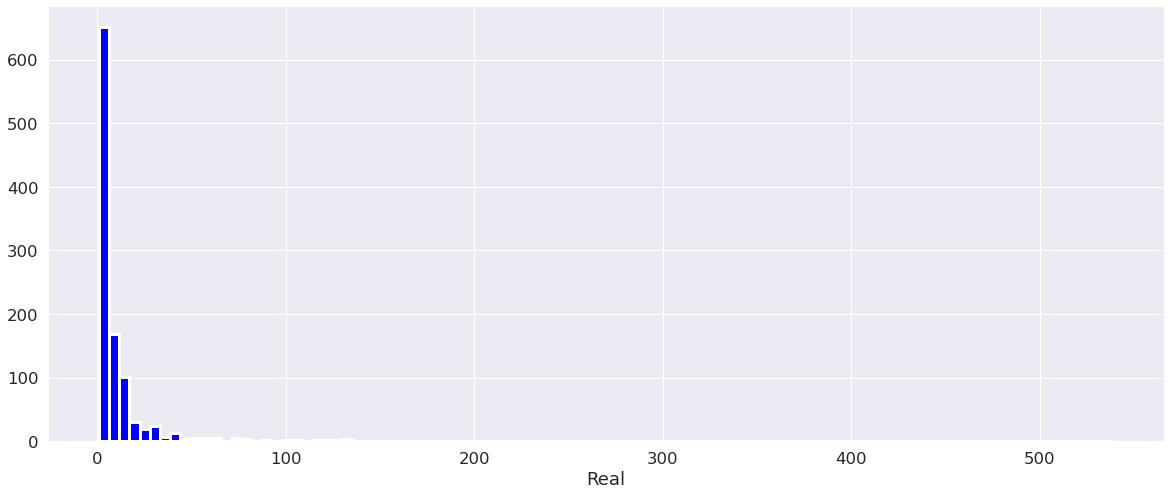

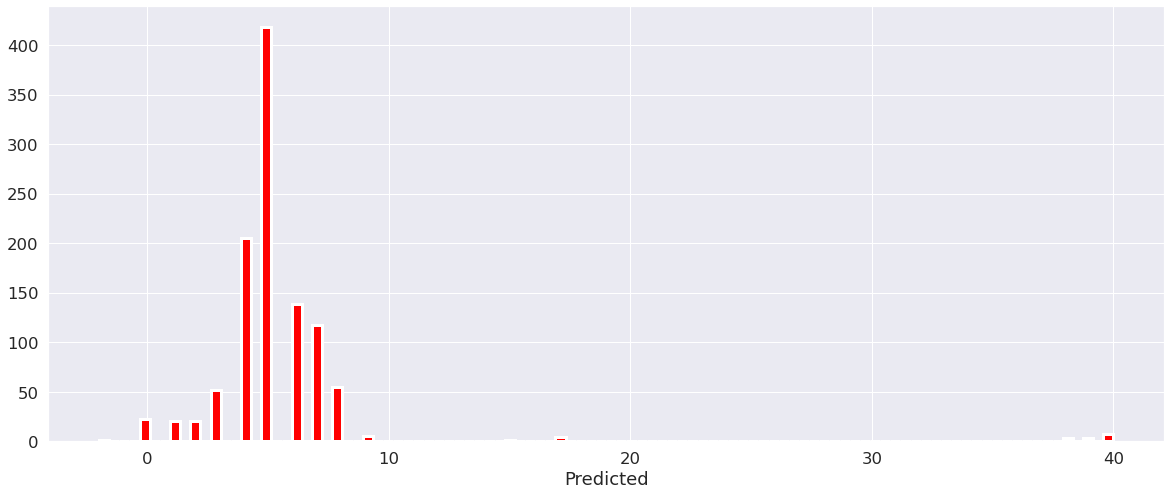


Validating mlp_q on set 6 and 2017-04
7626 1068
RMSE : 31.0517
MAPE': 1.3221
MDAPE': 0.7857
MSE: 964.2051
MAE: 9.6358
R2: -0.0085


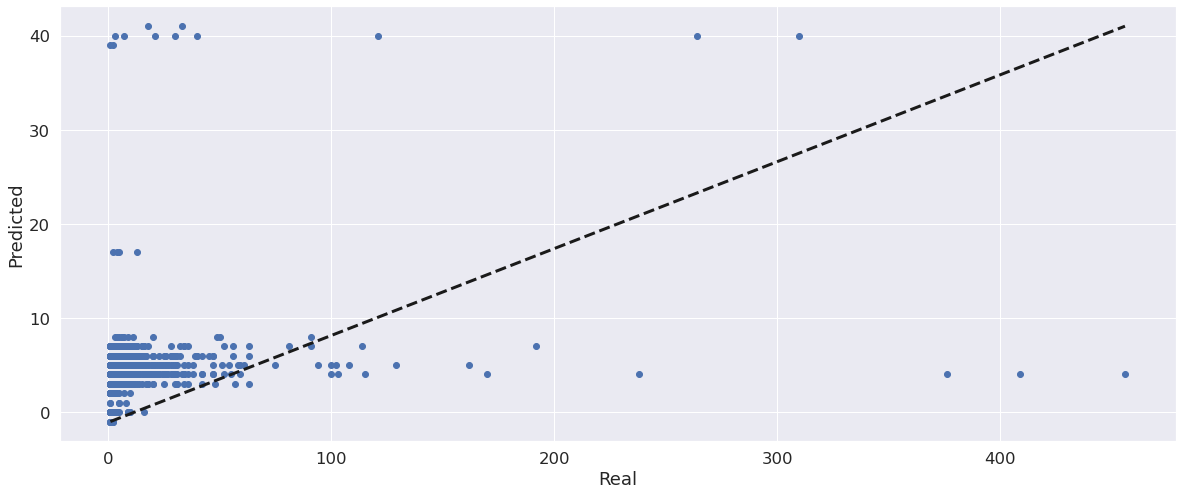

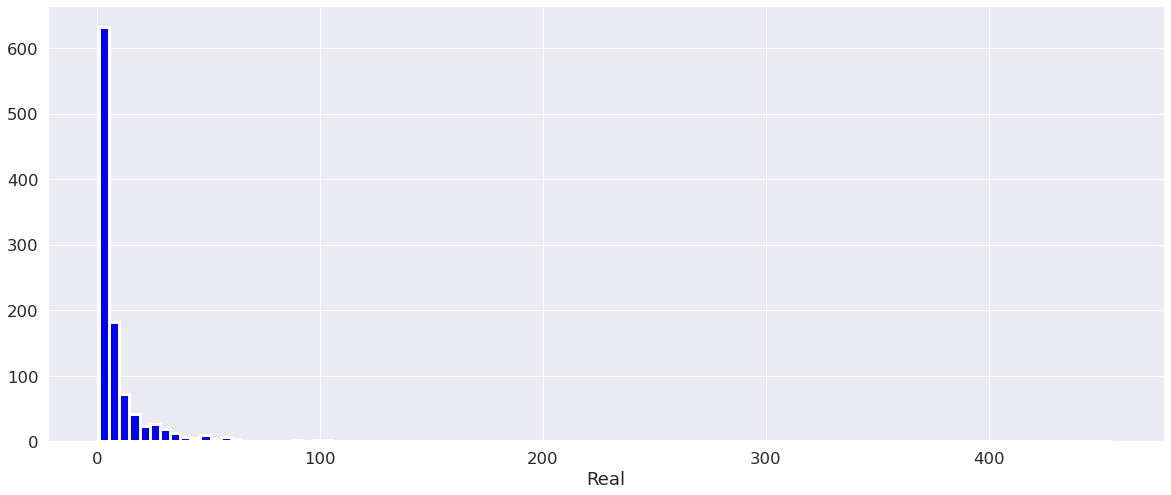

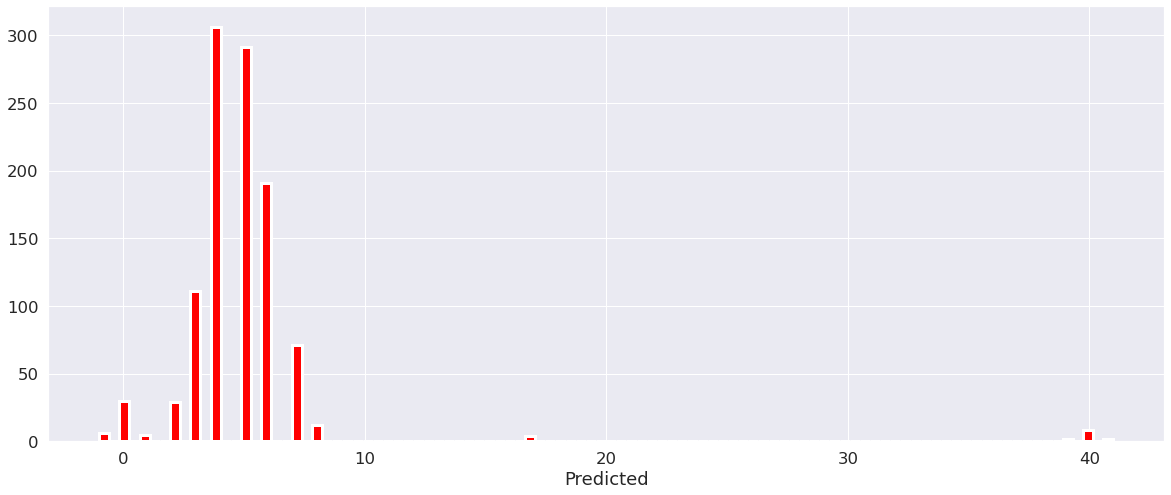


Validating mlp_q on set 6 and 2017-05
7626 1171
RMSE : 40.9024
MAPE': 1.0539
MDAPE': 0.6667
MSE: 1673.0077
MAE: 12.5021
R2: -0.0190


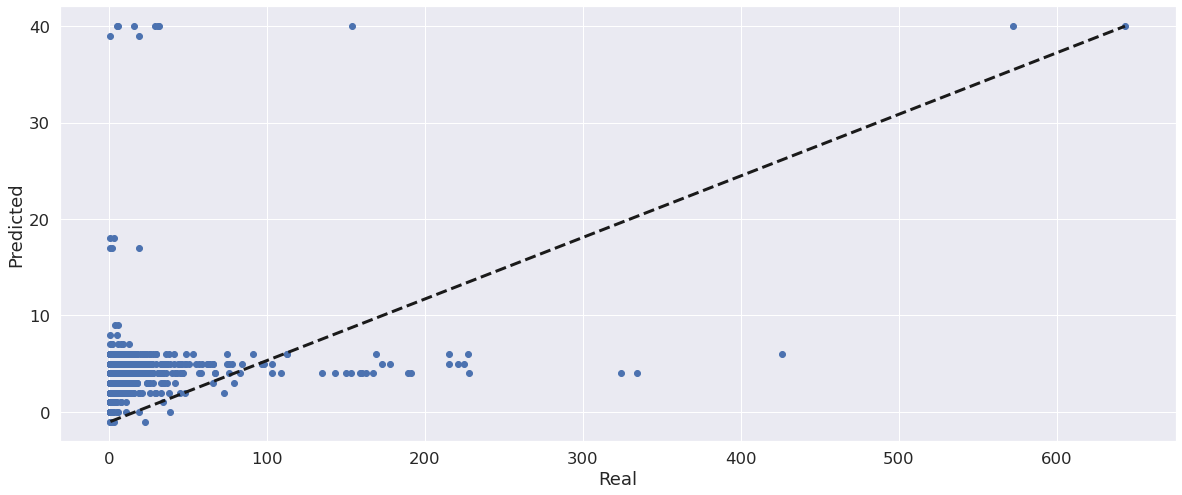

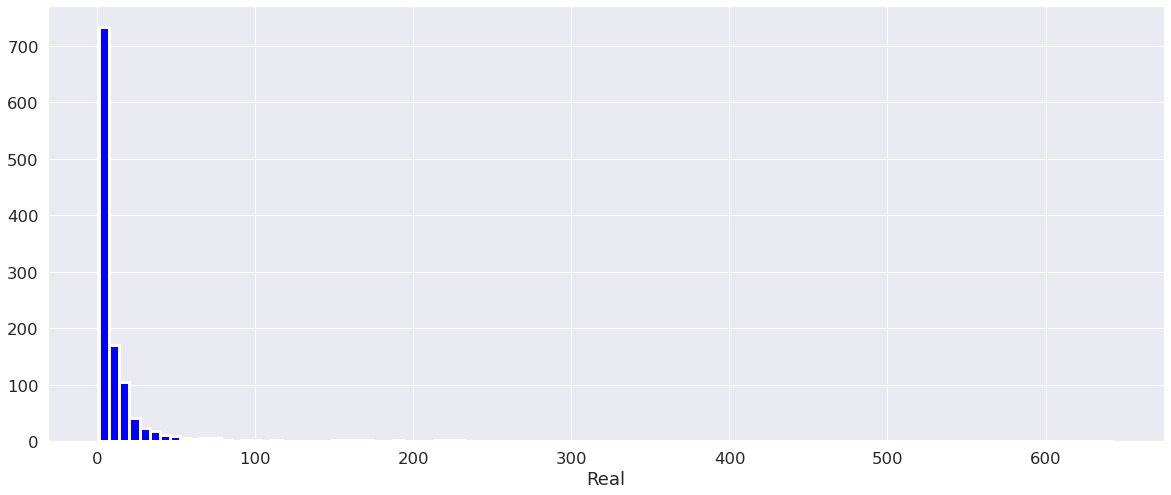

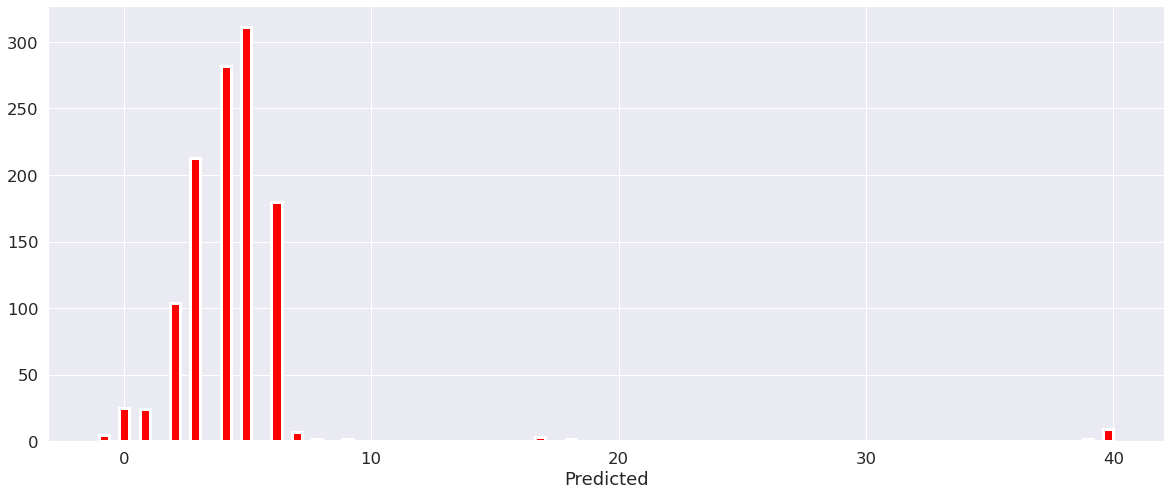

In [21]:
results = []
for r_name, r in regressors.items():
    s=6
    x_scaler = StandardScaler()

    df_set = df_train_val_test[(df_train_val_test.set == s)]

    x_scaler = MinMaxScaler()

    train_years = parse_str_list(df_set.train.values[0])
    val_years = parse_str_list(df_set.val.values[0])
    print(f'Training {r_name} on set {s}')

    df_train = df_dataset_v2[df_dataset_v2.year_month.isin(train_years)]    

    y_train = df_train['Y'].values    
    df_val = df_dataset_v2[df_dataset_v2.year_month.isin(val_years)]
    y_val = df_val['Y'].values
        
    if 'mlp' in r_name:
            r_inst = r.fit(X=x_scaler.fit_transform(df_train[X_cols]), y=y_train, 
                       X_val = x_scaler.transform(df_val[X_cols]), y_val = y_val)
    else: 
            r_inst = r.fit(X=x_scaler.fit_transform(df_train[X_cols]), y=y_train)
        
    for val_year in val_years:
        df_val = df_dataset_v2[df_dataset_v2.year_month == val_year]
        print(f'Validating {r_name} on set {s} and {val_year}')
        y_val = df_val['Y']
        y_pred_val = r_inst.predict(x_scaler.transform(df_val[X_cols]))

        y_pred_val = y_pred_val
        m = _metrics.applyRegressionMetrics(y=y_val, y_pred=y_pred_val)
        m['reg_inst'] = r_inst
        m['r_name'] = r_name
        m['set'] = s
        m['year_month'] = val_year
        results.append(m)
        print(len(y_train), len(y_val))
        _metrics.evaluateRegression(y=y_val, y_pred=y_pred_val)
        print()
df_results = pd.DataFrame(results)    

In [22]:
df_results[[c for c in df_results.columns if  c not in ['y', 'y_pred']]].sort_values('year_month')

,RMSE,MAPE,MDAPE,MSE,MAE,R2,reg_inst,r_name,set,year_month
0,23.064741,1.777255,0.676471,531.982293,9.350419,0.543920,LGBMRegressor(random_state=42),gbm,6,2017-03
3,27.802224,1.129885,0.600000,772.963653,9.504194,0.337322,"LGBMRegressor(alpha=0.5, metric='quantile', ob...",gbm_q,6,2017-03
6,32.562006,1.143051,0.666667,1060.284250,10.485555,0.090996,([DecisionTreeRegressor(criterion='friedman_ms...,gb_q,6,2017-03
9,34.140601,1.449191,0.761905,1165.580615,11.183597,0.000723,<src.mlp_quantile.QuantileModel object at 0x7f...,mlp_q,6,2017-03
1,23.658858,1.983519,0.666667,559.741573,9.239700,0.414556,LGBMRegressor(random_state=42),gbm,6,2017-04
4,24.951282,1.311399,0.625000,622.566479,8.594569,0.348846,"LGBMRegressor(alpha=0.5, metric='quantile', ob...",gbm_q,6,2017-04
7,29.418283,1.171602,0.666667,865.435393,9.058989,0.094825,([DecisionTreeRegressor(criterion='friedman_ms...,gb_q,6,2017-04
10,31.051651,1.322072,0.785714,964.205056,9.635768,-0.008481,<src.mlp_quantile.QuantileModel object at 0x7f...,mlp_q,6,2017-04
2,32.742207,1.725251,0.666667,1072.052092,11.210077,0.347021,LGBMRegressor(random_state=42),gbm,6,2017-05
5,35.247339,1.045287,0.642857,1242.374893,11.341588,0.243279,"LGBMRegressor(alpha=0.5, metric='quantile', ob...",gbm_q,6,2017-05
